# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
from functools import partial
import json
import os
from pathlib import Path
from PIL import Image

import cv2
# from imgaug.augmentables.kps import KeypointsOnImage
# from imgaug.augmentables.kps import Keypoint
# import imgaug.augmenters as iaa
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from pitch_geo import data
from pitch_geo.data import KeyPointsDataset
from pitch_geo.data import read_image_and_keypoints
import pitch_geo.models.augmentation as aug
import pitch_geo.models.metrics
from pitch_geo.models.metrics import NotVisiblePrecision, NotVisibleRecall 
import vis_utils

# Read the data frame

In [2]:
df = pd.read_csv('recruitment_task_pitch_geom/df_keypoints.csv')

I think that there is one row which is mislabeled. There shouldbe 39 instead of 38.

In [3]:
df = df[df['dataset'] == 'train']

In [4]:
key = df.query('kid == 38 and vis != 0')['image_path'].item()
idx1 = df.query(f'kid == 39 and image_path == "{key}"').index
idx2 = df.query(f'kid == 38 and image_path == "{key}"').index
df.loc[idx1, 'x'] = df.loc[idx2, 'x'].item()
df.loc[idx1, 'y'] = df.loc[idx2, 'y'].item()
df.loc[idx1, 'vis'] = df.loc[idx2, 'vis'].item()

Now when 'kid' is 38 the keypoint is always marked as invisible. Drop all the rows with 'kid' == 38 as they don't contain any information.

In [5]:
df = df[df['kid'] != 38]
df['kid'].nunique()

38

Normalize keypoints coordinates (we know that every picture is 1920 by 1080)

In [6]:
df['x'] = df['x'] / 1920
df['y'] = df['y'] / 1080

In [7]:
df['vis'] = df['vis'] != 0

# Define hyperparameters

In [8]:
IMG_SIZE = 240
BATCH_SIZE = 16
EPOCHS = 50
NUM_KEYPOINTS = 38  # 38 pairs each having x and y coordinates
DATA_FOLDER = Path('recruitment_task_pitch_geom')

# Define augmentation

In [9]:
# I have already openCV instlalled. The official albumentations library advices to install it in that way
# !pip install -U albumentations --no-binary qudida,albumentations

In [10]:
# augmentations definitions are moved to package

# Prepare the data loaders

In [11]:
# images_paths = df['image_path'].unique()

# train_paths, test_paths = train_test_split(images_paths, test_size=0.15, random_state=42, shuffle=True)

# train_df = df[df['image_path'].isin(train_paths)]
# val_df = df[~df['image_path'].isin(train_paths)]

# train_dataset = KeyPointsDataset(df=train_df, aug=test_aug, batch_size=BATCH_SIZE, train=True)
# val_dataset = KeyPointsDataset(df=val_df, aug=test_aug, batch_size=BATCH_SIZE, train=False)

# print(f"Total batches in training set: {len(train_dataset)}")
# print(f"Total batches in validation set: {len(val_dataset)}")

In [12]:
def load_image(
    path, image_size, num_channels, interpolation, crop_to_aspect_ratio=False
):
    """Load an image from a path and resize it. Taken from https://github.com/keras-team/keras/blob/v2.10.0/keras/utils/image_dataset.py#L30. """
    img = tf.io.read_file(path)
    img = tf.image.decode_image(
        img, channels=num_channels, expand_animations=False
    )
    if crop_to_aspect_ratio:
        img = image_utils.smart_resize(
            img, image_size, interpolation=interpolation
        )
    else:
        img = tf.image.resize(img, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img


annotations_dict = data.df_to_dict2(df)

def get_annotations(image_path):
    # image_path is supposed to be bytes object
    all_annotatios = annotations_dict[image_path.numpy().decode('utf-8')]
    
    # For tranining, we are only interested in keypoints coordinates:
    return all_annotatios['keypoints']

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

In [14]:
# tf.data.experimental.enable_debug_mode()

In [15]:
def edge_detect(image):
    # TO B&W
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img_grey, 100, 200)
    return edges

In [16]:
images_paths = df['image_path'].unique()

train_paths, test_paths = train_test_split(images_paths, test_size=0.15, random_state=42, shuffle=True)

# train_df = df[df['image_path'].isin(train_paths)]
# val_df = df[~df['image_path'].isin(train_paths)]

train_absolute_paths = [str(DATA_FOLDER / p) for p in  train_paths]
train_paths = tf.data.Dataset.from_tensor_slices(train_paths)
train_files = tf.data.Dataset.from_tensor_slices(train_absolute_paths)

train_images = (
    train_files
    .map(
        partial(
            load_image, 
            image_size=(IMG_SIZE, IMG_SIZE),
            num_channels=3,
            interpolation='bilinear'        
        ),
        num_parallel_calls=AUTOTUNE
    )
    .map(
        partial(tf.cast, dtype=tf.uint8),
        num_parallel_calls=AUTOTUNE
    )
    .map(
        lambda image: tf.numpy_function(func=edge_detect, inp=[image], Tout=tf.uint8),
        num_parallel_calls=AUTOTUNE
    )
)

# train_images = train_images.map(lambda x: x/255, num_parallel_calls=AUTOTUNE) #.cache()

# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
train_labels = (
    train_paths
    .map(
        lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16]),
        num_parallel_calls=AUTOTUNE
    )
    .map(lambda x: tf.reshape(x, (38, 3)))   # TODO do I need this reshaping or can I do it earlier?
    # .cache()
)

train_ds = tf.data.Dataset.zip((train_images, train_labels))

train_ds = (
    train_ds
    .shuffle(4000)
    .map(
        lambda image, keypoints: tf.numpy_function(func=aug.random_rotate, inp=[image, keypoints, 10, (0.5, 0.8)], Tout=[tf.uint8, tf.float16]),
        num_parallel_calls=AUTOTUNE
    )
    .map(
        lambda image, keypoints: tf.numpy_function(func=aug.random_translate, inp=[image, keypoints, 0.3], Tout=[tf.uint8, tf.float16]),
        num_parallel_calls=AUTOTUNE
    )
    .map(
        lambda image, keypoints: (
            tf.image.grayscale_to_rgb(tf.expand_dims(image, -1)), 
            tf.reshape(keypoints, [1, 1, NUM_KEYPOINTS * 3])
        ),
        num_parallel_calls=AUTOTUNE
    )
    .map(
        partial(aug.set_shapes, img_shape=(IMG_SIZE, IMG_SIZE, 3), labels_shape=(1, 1, NUM_KEYPOINTS * 3)), 
        num_parallel_calls=AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

2022-11-21 00:54:18.943258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 00:54:18.952311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 00:54:18.952629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 00:54:18.953597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

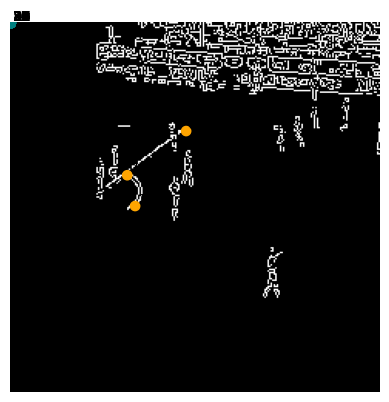

In [17]:
test_batch = next(iter(train_ds))
vis_utils.show_image_with_annotations(test_batch[0].numpy()[0,:] / 255, test_batch[1].numpy()[0,:], dot_radius=3, vis=True)

In [18]:
# %%time
# for i, batch in enumerate(train_ds):
#     print(f'{i + 1}/{len(train_ds)}', end='\r')
#     continue

In [19]:
# test_batch = next(iter(train_ds))
# vis_utils.show_image_with_annotations(test_batch[0].numpy()[0,:], test_batch[1].numpy()[0,:], dot_radius=3)

In [20]:
val_absolute_paths = [str(DATA_FOLDER / p) for p in  test_paths]
val_paths = tf.data.Dataset.from_tensor_slices(test_paths)
val_files = tf.data.Dataset.from_tensor_slices(val_absolute_paths)

val_images = (
    val_files.map(
        partial(
            load_image, 
            image_size=(IMG_SIZE, IMG_SIZE),
            num_channels=3,
            interpolation='bilinear'        
        ),
        num_parallel_calls=AUTOTUNE
    )
    .map(
        partial(tf.cast, dtype=tf.uint8),
        num_parallel_calls=AUTOTUNE
    )
    .map(
        lambda image: tf.numpy_function(func=edge_detect, inp=[image], Tout=tf.uint8),
        num_parallel_calls=AUTOTUNE
    )
)

# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
val_labels = val_paths.map(lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16])) # .cache()

val_ds = tf.data.Dataset.zip((val_images, val_labels))

val_ds = (
    val_ds
    .map(lambda image, keypoints: (image, tf.reshape(keypoints, [1, 1, NUM_KEYPOINTS * 3])), num_parallel_calls=AUTOTUNE)
    .map(
        lambda image, keypoints: (
            tf.image.grayscale_to_rgb(tf.expand_dims(image, -1)), 
            tf.reshape(keypoints, [1, 1, NUM_KEYPOINTS * 3])
        ),
        num_parallel_calls=AUTOTUNE
    )
    .map(
        partial(aug.set_shapes, img_shape=(IMG_SIZE, IMG_SIZE, 3), labels_shape=(1, 1, NUM_KEYPOINTS * 3)),
        num_parallel_calls=AUTOTUNE
    )
    .batch(BATCH_SIZE)
    # .map(keras.applications.mobilenet_v2.preprocess_input, num_parallel_calls=AUTOTUNE)
    .prefetch(buffer_size=AUTOTUNE)
)

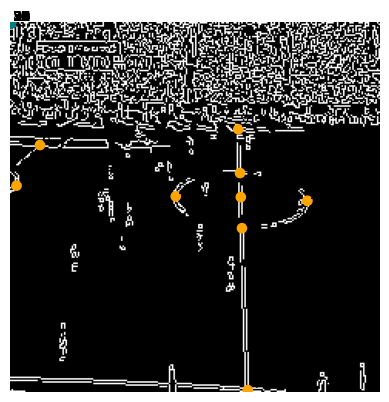

In [21]:
valtest_batch = next(iter(val_ds))
vis_utils.show_image_with_annotations(valtest_batch[0].numpy()[0,:], valtest_batch[1].numpy()[0,:], dot_radius=3, vis=True)

# The model

## Model building

In [22]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    # backbone = keras.applications.MobileNetV2(
    #     weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    # )
    backbone = keras.applications.EfficientNetB1(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    # x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    # x = backbone(x)
    # x = layers.Dropout(0.3)(x)
    # x = layers.SeparableConv2D(
        # NUM_KEYPOINTS * 3, kernel_size=5, strides=1, activation="relu"
    # )(x)
    # outputs = layers.SeparableConv2D(
        # NUM_KEYPOINTS * 3, kernel_size=3, strides=1, activation="sigmoid"
    # )(x)
    
    x = keras.applications.efficientnet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    # x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, 2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 2, 2, activation='relu')(x)
    x = layers.Dropout(0.05)(x)
    outputs = layers.Conv2D(3* NUM_KEYPOINTS, 2, 2, activation='sigmoid')(x)
    
    return keras.Model(inputs, outputs, name="keypoint_detector")

## Define callbacks

In [23]:
model_base_path = Path('checkpoints')
checkpoint_template_name = 'weights.{epoch:03d}-{val_loss:.5f}'
training_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = model_base_path / training_timestamp / checkpoint_template_name

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor="val_loss",
    save_best_only=False,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=Path('logs') / training_timestamp,
    write_graph=False
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_delta=0.0001,
    min_lr=0.000001,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    min_delta=0.0001,
    verbose=1,
)

## Compile the model

## Train the model

In [24]:
model = get_model()

model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(1e-3),
    metrics=[
        # NotVisiblePrecision(),
        # NotVisibleRecall()
    ],
    run_eagerly=False
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks = [
        model_checkpoint_callback,
        tensorboard_callback,
        reduce_lr,
        early_stopping
    ],
)

Epoch 1/50


2022-11-21 00:54:41.182329: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-21 00:54:42.831018: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


203/203 [==============================] - 33s 91ms/step - loss: 0.0474 - val_loss: 0.0221 - lr: 0.0010
Epoch 2/50
203/203 [==============================] - 22s 79ms/step - loss: 0.0241 - val_loss: 0.0164 - lr: 0.0010
Epoch 3/50
203/203 [==============================] - 22s 79ms/step - loss: 0.0207 - val_loss: 0.0160 - lr: 0.0010
Epoch 4/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0186 - val_loss: 0.0140 - lr: 0.0010
Epoch 5/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0174 - val_loss: 0.0142 - lr: 0.0010
Epoch 6/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0161 - val_loss: 0.0128 - lr: 0.0010
Epoch 7/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0158 - val_loss: 0.0118 - lr: 0.0010
Epoch 8/50
203/203 [==============================] - 22s 79ms/step - loss: 0.0148 - val_loss: 0.0116 - lr: 0.0010
Epoch 9/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0145 - val_lo

2022-11-21 00:58:25.373440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1060 of 4000
2022-11-21 00:58:35.368863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3024 of 4000


  2/203 [..............................] - ETA: 15s - loss: 0.0190    

2022-11-21 00:58:36.060131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


203/203 [==============================] - 37s 79ms/step - loss: 0.0139 - val_loss: 0.0107 - lr: 0.0010
Epoch 12/50
203/203 [==============================] - 24s 94ms/step - loss: 0.0135 - val_loss: 0.0104 - lr: 0.0010
Epoch 13/50
203/203 [==============================] - 22s 80ms/step - loss: 0.0126 - val_loss: 0.0103 - lr: 0.0010
Epoch 14/50
203/203 [==============================] - 22s 79ms/step - loss: 0.0125 - val_loss: 0.0101 - lr: 0.0010
Epoch 15/50
203/203 [==============================] - 24s 80ms/step - loss: 0.0126 - val_loss: 0.0121 - lr: 0.0010
Epoch 16/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0123 - val_loss: 0.0105 - lr: 0.0010
Epoch 17/50
203/203 [==============================] - 22s 79ms/step - loss: 0.0119 - val_loss: 0.0099 - lr: 0.0010
Epoch 18/50
203/203 [==============================] - 22s 79ms/step - loss: 0.0120 - val_loss: 0.0099 - lr: 0.0010
Epoch 19/50
203/203 [==============================] - 22s 79ms/step - loss: 0.0117 

2022-11-21 01:04:13.686954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1197 of 4000
2022-11-21 01:04:23.683749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3181 of 4000


  2/203 [..............................] - ETA: 15s - loss: 0.0101    

2022-11-21 01:04:24.001150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


203/203 [==============================] - 36s 79ms/step - loss: 0.0112 - val_loss: 0.0096 - lr: 0.0010
Epoch 27/50
203/203 [==============================] - ETA: 0s - loss: 0.0105
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
203/203 [==============================] - 22s 79ms/step - loss: 0.0105 - val_loss: 0.0095 - lr: 0.0010
Epoch 28/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0095 - val_loss: 0.0085 - lr: 2.0000e-04
Epoch 29/50
203/203 [==============================] - 22s 79ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 2.0000e-04
Epoch 30/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0080 - val_loss: 0.0082 - lr: 2.0000e-04
Epoch 31/50
203/203 [==============================] - 22s 80ms/step - loss: 0.0084 - val_loss: 0.0080 - lr: 2.0000e-04
Epoch 32/50
203/203 [==============================] - 22s 82ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 2.0000e-04
Epoch 33/50
203/203 [===============

2022-11-21 01:08:05.981674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1139 of 4000


  2/203 [..............................] - ETA: 16s - loss: 0.0110  

2022-11-21 01:08:09.628311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


203/203 [==============================] - 30s 79ms/step - loss: 0.0076 - val_loss: 0.0078 - lr: 2.0000e-04
Epoch 37/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0075 - val_loss: 0.0078 - lr: 2.0000e-04
Epoch 38/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0076 - val_loss: 0.0079 - lr: 2.0000e-04
Epoch 39/50


2022-11-21 01:09:18.238996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1827 of 4000


  2/203 [..............................] - ETA: 15s - loss: 0.0065  

2022-11-21 01:09:20.749712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


203/203 [==============================] - 28s 78ms/step - loss: 0.0075 - val_loss: 0.0075 - lr: 2.0000e-04
Epoch 40/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0072 - val_loss: 0.0075 - lr: 2.0000e-04
Epoch 41/50
203/203 [==============================] - 21s 78ms/step - loss: 0.0073 - val_loss: 0.0077 - lr: 2.0000e-04
Epoch 42/50


2022-11-21 01:10:29.387306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3146 of 4000
2022-11-21 01:10:29.585870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


203/203 [==============================] - 26s 79ms/step - loss: 0.0069 - val_loss: 0.0078 - lr: 2.0000e-04
Epoch 43/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0067 - val_loss: 0.0074 - lr: 2.0000e-04
Epoch 44/50
203/203 [==============================] - 23s 86ms/step - loss: 0.0069 - val_loss: 0.0080 - lr: 2.0000e-04
Epoch 45/50
203/203 [==============================] - 22s 80ms/step - loss: 0.0072 - val_loss: 0.0076 - lr: 2.0000e-04
Epoch 46/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0069 - val_loss: 0.0077 - lr: 2.0000e-04
Epoch 47/50
203/203 [==============================] - 21s 79ms/step - loss: 0.0071 - val_loss: 0.0074 - lr: 2.0000e-04
Epoch 48/50
203/203 [==============================] - ETA: 0s - loss: 0.0070
Epoch 48: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
203/203 [==============================] - 21s 79ms/step - loss: 0.0070 - val_loss: 0.0076 - lr: 2.0000e-04
Epoch 49/50
203/203 [=======

In [25]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

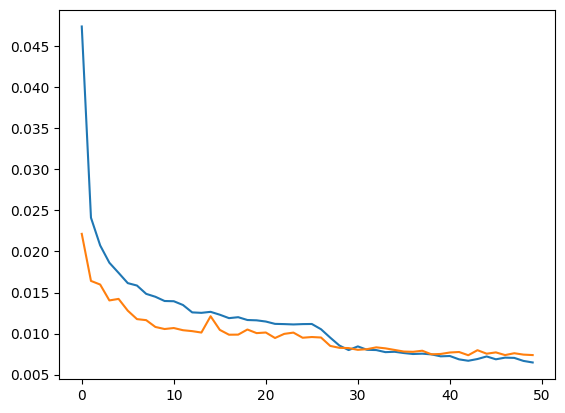

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [27]:
# history.history['val_loss']

In [28]:
model = get_model()

In [29]:
!ls checkpoints/ -l

total 136
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 18 14:59 20221118_145512
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 18 15:10 20221118_150546
drwxr-xr-x 2 tensorflow-user tensorflow-user 12288 Nov 18 16:15 20221118_155924
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 19 14:26 20221119_142421
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 19 14:29 20221119_142703
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 19 14:33 20221119_143009
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 19 14:37 20221119_143323
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 19 23:40 20221119_232014
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 19 23:45 20221119_234348
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 19 23:57 20221119_235602
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 20 00:18 20221120_001529
drwxr-xr-x 2 tensorflow-user tensorflow-user  4096 Nov 20 00:22 20221120_002208
drwxr-xr-x 2 tensorflow-user t

In [30]:
# str(model_path).format(epoch=20, val_loss=0.02)

In [31]:
# model.load_weights(filepath=str(model_path).format(epoch=20, val_loss=0.02))

In [32]:
# model.load_weights('checkpoints/20221120_125715/weights.20-0.01')

In [44]:
# model.load_weights('checkpoints/20221121_005426/weights.050-0.00739')
# model.compile(
#     loss='mean_squared_error',
#     optimizer=keras.optimizers.Adam(1e-3),
#     metrics=[
#     ],
# )

In [46]:
sample_val_images, sample_val_keypoints = next(iter(val_ds))
sample_val_images = sample_val_images
sample_val_keypoints = sample_val_keypoints.numpy()  # .reshape(-1, 38, 2)

predictions = model.predict(sample_val_images)    # .reshape(-1, 38, 2)

1/1 [==============================] - 2s 2s/step


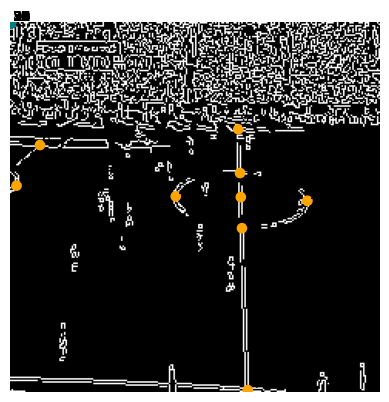

In [47]:
# Ground-truth
vis_utils.show_image_with_annotations(sample_val_images.numpy()[0,:] / 255., sample_val_keypoints[0,:], dot_radius=3, vis=True)

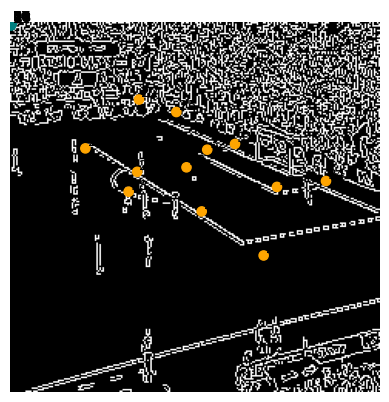

In [48]:
# Predictions
vis_utils.show_image_with_annotations(sample_val_images.numpy()[1,:] / 255., predictions[1], dot_radius=3, normalized=True, vis=True)

(array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  8.]),
 array([1.07768940e-08, 9.99987125e-02, 1.99997410e-01, 2.99996108e-01,
        3.99994820e-01, 4.99993503e-01, 5.99992216e-01, 6.99990928e-01,
        7.99989581e-01, 8.99988294e-01, 9.99987006e-01]),
 <BarContainer object of 10 artists>)

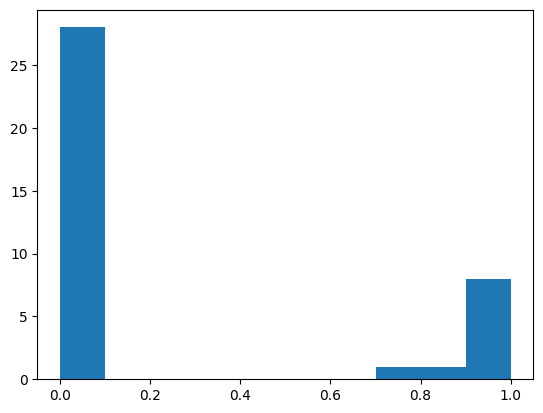

In [49]:
plt.hist(predictions[0].reshape(38, 3)[:, 2])

In [39]:
# model.evaluate(x=sample_val_images[:3], y=sample_val_keypoints[:3])

# Accuracy of predicting visible vs invisible

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [51]:
vis = df[df['image_path'].isin(test_paths)]['vis']
print(f"% of invisible keypoints in validation set: {(vis == False).mean():0.2%}")

% of invisible keypoints in validation set: 76.76%


In [52]:
y_hat = model.predict(val_ds)

36/36 [==============================] - 5s 77ms/step


In [53]:
vis_hat = y_hat.reshape(574, NUM_KEYPOINTS, 3)[:, :, 2] > 0.1
(vis_hat.reshape(-1) == vis).mean()

0.6898496240601504

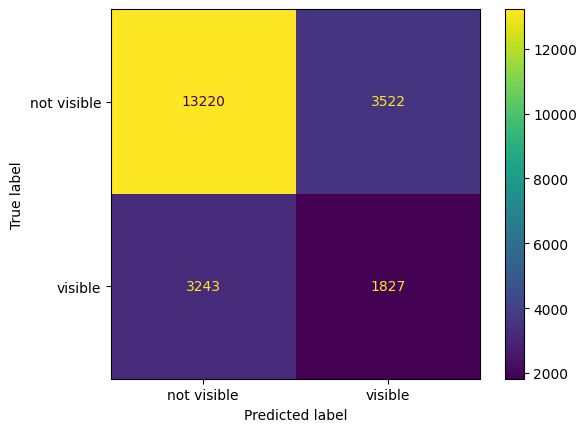

In [54]:
cm =confusion_matrix(vis, vis_hat.reshape(-1))
disp = ConfusionMatrixDisplay(cm, display_labels=['not visible', 'visible'])
disp.plot()
plt.show()

In [55]:
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * precision * recall / (precision + recall)

In [56]:
print(f'classifying points as invisible:')
print(f'precision:\t{precision:.4f}')
print(f'recall:\t\t{recall:.4f}')
print(f'f1 score:\t{f1_score:.4f}')

classifying points as invisible:
precision:	0.3416
recall:		0.3604
f1 score:	0.3507


# Analysis of losses

## Histogram of losses

Are there any special cases with big loss, or is the loss evenly spread across all the samples?

In [ ]:
y_true.shape

In [ ]:
model.evaluate(val_ds)

In [ ]:
y

In [ ]:
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
# val_df = df[df['image_path'].isin(test_paths)]
# y_true = val_df[['x', 'y', 'vis']].values.astype(np.float32)

In [ ]:
y_true.shape

In [ ]:
y.shape

In [ ]:
y.reshape(-1).shape

In [ ]:
mse(y_true, y.reshape(-1, 3))

In [ ]:
loss = []
for i in range(y.shape[0]):
    loss.append(mse(y_true[i], y_hat[i]))

In [ ]:
plt.hist(loss)


In [ ]:
y_true.shape

In [ ]:
y.shape

In [ ]:
mse(y_true, y_hat)

In [ ]:
np.mean(loss)

# Performance of a naive model

Is the loss 0.0458 big or small? To understand a bit the magnitude of a loss, let's consider a loss of a model predicting every point to lie in a center of a frame. Or in $(0, 0)$ point.

In [ ]:
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
y_true = []
for _, y in val_ds:
    y_true.append(y.numpy())
    
y_true = np.vstack(y_true)

In [ ]:
y_true.shape

In [ ]:
y_naive = np.ones_like(y_true) * 0.5
print(mse(y_true, y_naive))

In [ ]:
y_naive = np.zeros_like(y_true)
print(mse(y_true, y_naive))

It looks as if the most reasonable thing the model can do is to always predict (0, 0)!

I can fight it either with using augmentation that would cuase the upperleft corner to move, or with a different loss function, that would more penalize predict (0, 0) (not visible) if the ground truth keypoint is actually visible. But the first option is easier.